In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

source_dir = os.path.join("combined_dataset", "MALIGNANT")
augmented_dir = os.path.join("combined_dataset", "malignant_augmented")
os.makedirs(augmented_dir, exist_ok=True)

# Image augmentation settings
augmentor = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Number of augmentations per image
augment_count = 4

for fname in os.listdir(source_dir):
    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(source_dir, fname)
        image = load_img(img_path, target_size=(224, 224))  # Resize as needed
        image_array = img_to_array(image)
        image_array = image_array.reshape((1,) + image_array.shape)

        i = 0
        for batch in augmentor.flow(
            image_array,
            batch_size=1,
            save_to_dir=augmented_dir,
            save_prefix="IMG",
            save_format="jpg"
        ):
            i += 1
            if i >= augment_count:
                break

print(f"Augmentation complete. Images saved to {augmented_dir}")


Augmentation complete. Images saved to combined_dataset\malignant_augmented


In [15]:
number_of_images = {}

for dir in os.listdir("combined_dataset"):
   number_of_images[dir] = len(os.listdir(os.path.join("combined_dataset",dir)))
   print("",dir,"" ,number_of_images[dir])

 benign  9528
 malignant_augmented  8692
 MALIGNANT_OG  2455


NotADirectoryError: [WinError 267] The directory name is invalid: 'combined_dataset\\metadata.csv'

In [ ]:
import os
import shutil
import random

combined_dir = "combined_dataset"
malignant_dirs = ["malignant_augmented"]
benign_dir = "benign"

output_base = "final_dataset"
splits = ['train', 'test', 'val']
split_ratios = {'train': 0.7, 'test': 0.15, 'val': 0.15}
os.makedirs(output_base, exist_ok=True)

for split in splits:
    for label in ['benign', 'malignant']:
        os.makedirs(os.path.join(output_base, split, label), exist_ok=True)

def collect_images(folder):
    return [os.path.join(folder, fname) for fname in os.listdir(folder) if fname.lower().endswith(('.jpg', '.jpeg', '.png'))]

benign_images = collect_images(os.path.join(combined_dir, benign_dir))
malignant_images = []
for m_dir in malignant_dirs:
    malignant_images.extend(collect_images(os.path.join(combined_dir, m_dir)))

random.shuffle(benign_images)
random.shuffle(malignant_images)

def split_and_copy(images, label):
    total = len(images)
    train_end = int(split_ratios['train'] * total)
    test_end = train_end + int(split_ratios['test'] * total)

    split_paths = {
        'train': images[:train_end],
        'test': images[train_end:test_end],
        'val': images[test_end:]
    }

    for split, paths in split_paths.items():
        for src_path in paths:
            fname = os.path.basename(src_path)
            dest_path = os.path.join(output_base, split, label, fname)
            shutil.copy(src_path, dest_path)

split_and_copy(benign_images, 'benign')
split_and_copy(malignant_images, 'malignant')

print("Dataset successfully split into train, test, and val folders.")


Dataset successfully split into train, test, and val folders.


In [23]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

output_base = "final_dataset"
base_dir = output_base
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-4

# Image Data Generators
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_test_aug = ImageDataGenerator(rescale=1./255)

train_gen = train_aug.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary"
)

val_gen = val_test_aug.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary"
)

test_gen = val_test_aug.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary", shuffle=False
)

# Build Model
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss="binary_crossentropy", metrics=["accuracy"])

# Callbacks
checkpoint_path = "best_mobilenet_model.h5"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
]

# Train
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=callbacks
)

# Evaluate
loss, acc = model.evaluate(test_gen)
print(f"Test Accuracy: {acc*100:.2f}%")

# Classification Report
preds = model.predict(test_gen)
y_pred = (preds > 0.5).astype("int32")
y_true = test_gen.classes
print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))


Found 12753 images belonging to 2 classes.
Found 2735 images belonging to 2 classes.
Found 2732 images belonging to 2 classes.
Epoch 1/20
399/399 [==============================] - 378s 943ms/step - loss: 0.5110 - accuracy: 0.7524 - val_loss: 0.4065 - val_accuracy: 0.8307
Epoch 2/20
399/399 [==============================] - 170s 426ms/step - loss: 0.4150 - accuracy: 0.8131 - val_loss: 0.3732 - val_accuracy: 0.8537
Epoch 3/20
399/399 [==============================] - 305s 765ms/step - loss: 0.3873 - accuracy: 0.8281 - val_loss: 0.3616 - val_accuracy: 0.8574
Epoch 4/20
399/399 [==============================] - 204s 510ms/step - loss: 0.3687 - accuracy: 0.8382 - val_loss: 0.3465 - val_accuracy: 0.8618
Epoch 5/20
399/399 [==============================] - 163s 408ms/step - loss: 0.3584 - accuracy: 0.8407 - val_loss: 0.3577 - val_accuracy: 0.8596
Epoch 6/20
399/399 [==============================] - 167s 420ms/step - loss: 0.3466 - accuracy: 0.8466 - val_loss: 0.3534 - val_accuracy: 0.86

86/86 [==============================] - 21s 241ms/step
AUC Score: 0.9391


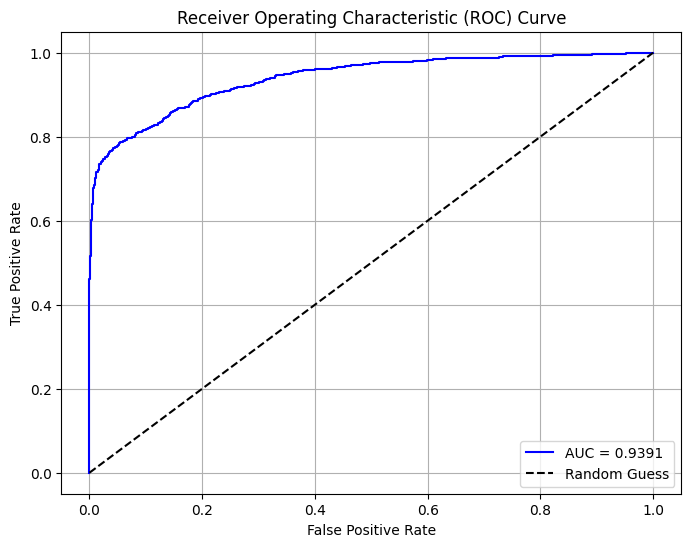

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

y_probs = model.predict(test_gen)
y_true = test_gen.classes


auc_score = roc_auc_score(y_true, y_probs)
print(f"AUC Score: {auc_score:.4f}")

fpr, tpr, thresholds = roc_curve(y_true, y_probs)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model("best_mobilenet_model.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open("mobilenet_skin_classifier.tflite", "wb") as f:
    f.write(tflite_model)

print("Model converted and saved as mobilenet_skin_classifier.tflite")


INFO:tensorflow:Assets written to: C:\Users\lenovo\AppData\Local\Temp\tmpeh_cjzdq\assets


INFO:tensorflow:Assets written to: C:\Users\lenovo\AppData\Local\Temp\tmpeh_cjzdq\assets


Model converted and saved as mobilenet_skin_classifier.tflite


In [26]:
print(train_gen.class_indices)


{'benign': 0, 'malignant': 1}


In [ ]:
from sklearn.metrics import roc_curve

y_probs = model.predict(test_gen)  
y_true = test_gen.classes           

fpr, tpr, thresholds = roc_curve(y_true, y_probs)

# Find the threshold that gives best TPR-FPR (Youden's index)
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.4f}")


86/86 [==============================] - 22s 243ms/step
Optimal threshold: 0.3943


In [35]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the best model (just in case not already loaded)
model = tf.keras.models.load_model("best_mobilenet_model.h5")

# Class labels (based on class_indices)
class_labels = {0: 'benign', 1: 'malignant'}

# Path to your test image
img_path = 'combined_dataset/benign/IMG_15.jpg'

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)[0][0]

# Show result
label = class_labels[int(prediction > 0.3943)]
confidence = prediction if prediction > 0.3943 else 1 - prediction
print(f"Predicted: {label} ({confidence*100:.2f}% confidence)")


1/1 [==============================] - 0s 412ms/step
Predicted: benign (97.93% confidence)


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

# Paths
output_base = "final_dataset"
base_dir = output_base
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-4
NUM_CLASSES = 2  

# Image Data Generators
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_test_aug = ImageDataGenerator(rescale=1./255)

train_gen = train_aug.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_test_aug.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_gen = val_test_aug.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Build Model
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights="imagenet")
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss="categorical_crossentropy", metrics=["accuracy"])

# Callbacks
checkpoint_path = "best_mobilenet_model_softmax.h5"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
]

# Train
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=callbacks
)

# Evaluate
loss, acc = model.evaluate(test_gen)
print(f"Test Accuracy: {acc*100:.2f}%")

# Predict
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

# Report
print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))


Found 12753 images belonging to 2 classes.
Found 2735 images belonging to 2 classes.
Found 2732 images belonging to 2 classes.
Epoch 1/20
399/399 [==============================] - 209s 516ms/step - loss: 0.5207 - accuracy: 0.7495 - val_loss: 0.3768 - val_accuracy: 0.8457
Epoch 2/20
399/399 [==============================] - 170s 425ms/step - loss: 0.3994 - accuracy: 0.8229 - val_loss: 0.3766 - val_accuracy: 0.8527
Epoch 3/20
399/399 [==============================] - 167s 419ms/step - loss: 0.3734 - accuracy: 0.8396 - val_loss: 0.3504 - val_accuracy: 0.8600
Epoch 4/20
399/399 [==============================] - 170s 425ms/step - loss: 0.3571 - accuracy: 0.8421 - val_loss: 0.3552 - val_accuracy: 0.8622
Epoch 5/20
399/399 [==============================] - 165s 413ms/step - loss: 0.3466 - accuracy: 0.8481 - val_loss: 0.3520 - val_accuracy: 0.8629
Epoch 6/20
399/399 [==============================] - 166s 416ms/step - loss: 0.3471 - accuracy: 0.8442 - val_loss: 0.3366 - val_accuracy: 0.86

In [37]:
model = tf.keras.models.load_model("best_mobilenet_model_softmax.h5")


converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("mobilenet_softmax_model.tflite", "wb") as f:
    f.write(tflite_model)

print("Model converted and saved as mobilenet_softmax_model.tflite")


INFO:tensorflow:Assets written to: C:\Users\lenovo\AppData\Local\Temp\tmpo8hsjrze\assets


INFO:tensorflow:Assets written to: C:\Users\lenovo\AppData\Local\Temp\tmpo8hsjrze\assets


Model converted and saved as mobilenet_softmax_model.tflite


AUC Score: 0.9408


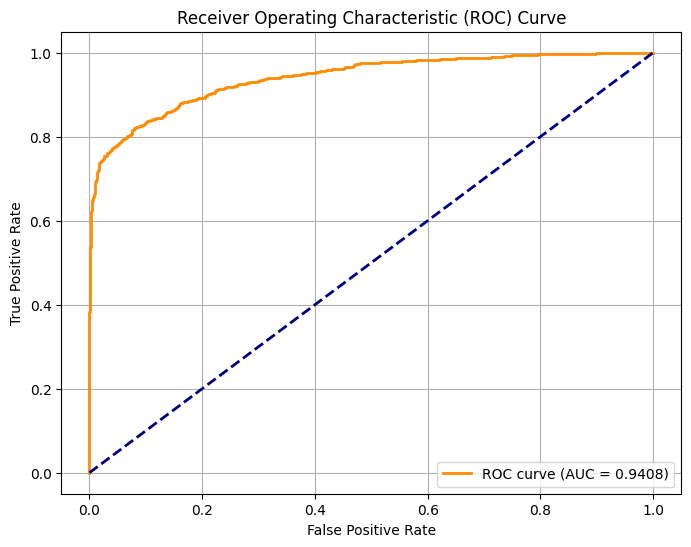

In [39]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Use predicted probabilities for class 1
# preds already computed in previous code
y_score = preds[:, 1]  # probability of class 1
y_true = test_gen.classes

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Print AUC Score
print(f"AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


86/86 [==============================] - 23s 258ms/step
Optimal threshold: 0.3210
AUC Score: 0.9408


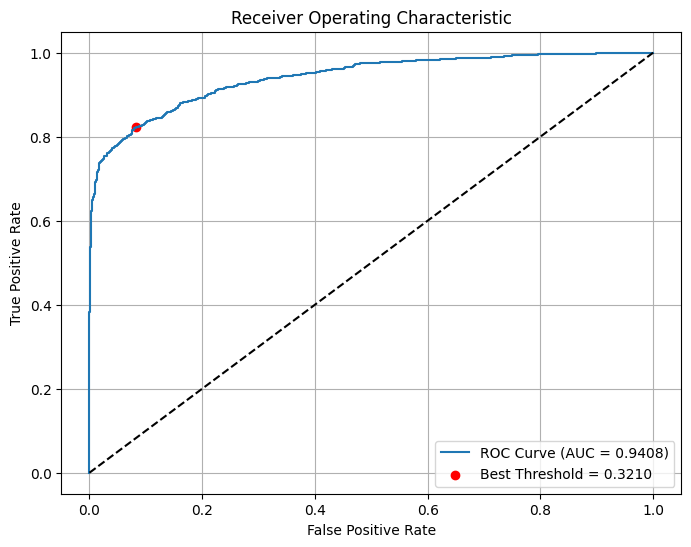

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred_probs = model.predict(test_gen)  
y_true = test_gen.classes  

y_scores = y_pred_probs[:, 1]

# === Compute ROC and AUC ===
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

# === Print and Plot ===
print(f"Optimal threshold: {best_thresh:.4f}")
print(f"AUC Score: {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  
plt.scatter(fpr[ix], tpr[ix], color='red', label=f'Best Threshold = {best_thresh:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_score)

# Youden's J statistic
j_scores = tpr - fpr
optimal_idx = j_scores.argmax()
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.4f}")


Optimal threshold: 0.3210


In [43]:
print(test_gen.class_indices)


{'benign': 0, 'malignant': 1}


In [60]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load model
model = load_model('best_mobilenet_model_softmax.h5')

# img_path = 'combined_dataset/benign/IMG_15.jpg'
img_path = 'combined_dataset/MALIGNANT_OG/IMG_8079.jpg'
img = image.load_img(img_path, target_size=(224, 224))  # change size as per your model
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # shape: (1, H, W, 3)
img_array = img_array / 255.0  # normalize if required by your training pipeline

# Predict
pred_probs = model.predict(img_array)[0]  # shape: (2,) because softmax
malignant_prob = pred_probs[1]  # index 1 is usually for malignant

# Use threshold
threshold = 0.3210
predicted_class = 1 if malignant_prob >= threshold else 0

# Map class index to label
class_indices = {0: 'benign', 1: 'malignant'}
print(f"Predicted class: {class_indices[predicted_class]}")
print(f"Malignant probability: {malignant_prob:.4f}")


1/1 [==============================] - 0s 389ms/step
Predicted class: malignant
Malignant probability: 0.4638
